In [10]:
# # 기본 설정 및 라이브러리 임포트

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, ttest_ind

# 한글 폰트 설정 (Windows 기준, 다른 OS는 폰트명 변경 필요)
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# Seaborn 스타일 설정
sns.set_theme(style="whitegrid", font="Malgun Gothic")

In [11]:
# # 1. 데이터 로딩
# ## 데이터 파일 경로를 사용자의 환경에 맞게 수정해주세요.
# ## 예시: 'data/서울버스 일별 시간대별 승하차 인원.csv'
# ## 원본 노트북의 경로를 그대로 사용하시거나, 현재 노트북 파일과 같은 위치에 데이터를 두고 파일명만 사용하세요.

try:
    # 원본 노트북의 경로를 사용하려면 아래 주석을 해제하고 파일이 있는지 확인하세요.
    # bus_df_raw = pd.read_csv('C:/Users/user/Desktop/데이터/압축푼데이터/서울버스 일별 시간대별 승하차 인원.csv', encoding='euc-kr')
    # subway_df_raw = pd.read_csv('C:/Users/user/Desktop/데이터/압축푼데이터/서울철도 일별 시간대별 승하차 인원.csv', encoding='euc-kr')
    # weather_df_raw = pd.read_csv('C:/Users/user/Desktop/데이터/압축푼데이터/OBS_ASOS_TIM_20250509144620.csv', encoding='euc-kr') # 파일명으로 보아 2013년 데이터로 추정됩니다. 기간 확인 필수!

    # 아래는 현재 폴더에 파일이 있거나, 'data' 하위 폴더에 있다고 가정하고 파일명만 사용하는 예시입니다.
    # 실제 파일명과 경로로 수정해주세요.
    bus_df_raw = pd.read_csv('서울버스 일별 시간대별 승하차 인원.csv', encoding='euc-kr')
    subway_df_raw = pd.read_csv('서울철도 일별 시간대별 승하차 인원.csv', encoding='euc-kr')
    weather_df_raw = pd.read_csv('OBS_ASOS_TIM_20250509144620.csv', encoding='euc-kr')


except FileNotFoundError:
    print("오류: 데이터 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
    # 예시용 빈 데이터프레임 생성 (오류 방지용)
    bus_df_raw = pd.DataFrame()
    subway_df_raw = pd.DataFrame()
    weather_df_raw = pd.DataFrame()

# 데이터 샘플 확인 (만약 파일 로딩에 성공했다면)
if not bus_df_raw.empty:
    print("--- 버스 데이터 샘플 ---")
    print(bus_df_raw.head())
if not subway_df_raw.empty:
    print("\n--- 지하철 데이터 샘플 ---")
    print(subway_df_raw.head())
if not weather_df_raw.empty:
    print("\n--- 날씨 데이터 샘플 ---")
    print(weather_df_raw.head())

print("\n--- 데이터 로딩 완료 (샘플 데이터가 출력되지 않았다면 파일 경로 확인 필요) ---")

--- 버스 데이터 샘플 ---
         운행일자      노선ID                      노선    정류장ID       정류장  \
0  2014-12-01  11110329          6411번(구로동~개포동)  9009281    신트리아파트   
1  2014-08-15  11110556    7730번(은평공영차고지~이북오도청)  9001990  월곡동두산아파트   
2  2015-06-05  11110677  2312번(중랑공영차고지~강동공영차고지)  8501523    경문고등학교   
3  2015-04-12  11110899     670번(온수동~디지털미디어시티역)  9000198     성내주유소   
4  2015-03-19  11110323    240번(중랑공영차고지~신사역사거리)  9001139    중앙동성당앞   

              승차시간구분  시간구분ID  승차총승객수  하차총승객수  
0  19:00:00~19:59:59      30       6       4  
1  13:00:00~13:59:59       0       6       0  
2  19:00:00~19:59:59      30       1      14  
3  23:00:00~23:59:59       0      19       1  
4  11:00:00~11:59:59      30       1       2  

--- 지하철 데이터 샘플 ---
         운행일자  호선ID   호선   역ID     역             승차시간구분  30분시간구간ID  승차총승객수  \
0  2014-05-21   206  6호선  2626    대흥  21:00:00~21:59:59         30     110   
1  2015-01-15   208  8호선  2826    수진  22:00:00~22:59:59          0      69   
2  2014-07-18   206  6호선 

In [12]:
# # 2. 데이터 전처리

# ## 2.1. 대중교통 데이터 전처리 (버스 + 지하철)
# ### 버스 데이터와 지하철 데이터의 컬럼명이 다를 수 있으므로, 통일하거나 필요한 컬럼만 선택합니다.
# ### 여기서는 원본 노트북의 컬럼명을 기준으로 처리합니다.

def preprocess_transport_data(df, transport_type):
    if df.empty:
        return pd.DataFrame(columns=['날짜', '시간', '총승객수']) # 빈 데이터프레임 반환
        
    temp_df = df.copy()
    # '운행일자' 또는 '사용일자'를 datetime으로 변환
    date_col = '운행일자' if '운행일자' in temp_df.columns else '사용일자'
    temp_df['날짜'] = pd.to_datetime(temp_df[date_col])
    
    # '승차시간구분' 또는 '시간대별'에서 시간(hour) 추출
    # 버스 데이터: '00:00:00~00:59:59' 형식 -> 앞 두 글자 추출
    # 지하철 데이터: '00시-01시' 또는 숫자(0~23) 형식일 수 있음 -> 예시에서는 버스와 유사하다고 가정
    time_col = '승차시간구분' if '승차시간구분' in temp_df.columns else '시간대별' # 지하철 컬럼명 확인 필요
    
    if temp_df[time_col].dtype == 'object': # 문자열 타입인 경우
         temp_df['시간'] = temp_df[time_col].astype(str).str[:2].astype(int)
    else: # 이미 숫자형인 경우 (예: 0, 1, ... 23)
        temp_df['시간'] = temp_df[time_col].astype(int)

    # 승객 수 컬럼 확인 (승차총승객수, 하차총승객수)
    on_col = '승차총승객수' if '승차총승객수' in temp_df.columns else '승차총 인원' # 지하철 컬럼명 확인 필요
    off_col = '하차총승객수' if '하차총승객수' in temp_df.columns else '하차총 인원' # 지하철 컬럼명 확인 필요
    
    temp_df['총승객수'] = temp_df[on_col].fillna(0) + temp_df[off_col].fillna(0)
    
    # 필요한 컬럼만 선택 및 일자별, 시간별 집계
    # 노선이나 정류장별 분석이 아니므로, 전체 승객수로 집계
    agg_df = temp_df.groupby([temp_df['날짜'].dt.date, '시간'])['총승객수'].sum().reset_index()
    agg_df['날짜'] = pd.to_datetime(agg_df['날짜']) # 날짜 컬럼을 다시 datetime으로
    return agg_df

# 데이터가 로드 되었을 경우에만 전처리 실행
if not bus_df_raw.empty and not subway_df_raw.empty:
    bus_df = preprocess_transport_data(bus_df_raw, '버스')
    subway_df = preprocess_transport_data(subway_df_raw, '지하철')

    # 버스와 지하철 데이터 통합 (날짜와 시간 기준으로 합산)
    # 컬럼명이 다를 수 있으므로, preprocess_transport_data 함수에서 통일된 컬럼명('날짜', '시간', '총승객수') 사용
    transport_df = pd.concat([bus_df, subway_df]).groupby(['날짜', '시간'])['총승객수'].sum().reset_index()
    
    print("\n--- 대중교통 데이터 전처리 후 샘플 (transport_df) ---")
    print(transport_df.head())
    print(f"처리된 대중교통 데이터 기간: {transport_df['날짜'].min()} ~ {transport_df['날짜'].max()}")
else:
    print("대중교통 데이터가 로드되지 않아 전처리를 건너뜁니다.")
    transport_df = pd.DataFrame(columns=['날짜', '시간', '총승객수'])


--- 대중교통 데이터 전처리 후 샘플 (transport_df) ---
          날짜  시간  총승객수
0 2014-01-02   5    63
1 2014-01-02   9   485
2 2014-01-03  23   466
3 2014-01-04   9     2
4 2014-01-04  10   309
처리된 대중교통 데이터 기간: 2014-01-02 00:00:00 ~ 2015-10-31 00:00:00


In [13]:
# ## 2.2. 날씨 데이터 전처리
# ### 원본 날씨 데이터(OBS_ASOS_TIM)는 시간별 데이터입니다.

if not weather_df_raw.empty:
    weather_df = weather_df_raw.copy()
    # '일시' 컬럼을 datetime으로 변환
    weather_df['datetime'] = pd.to_datetime(weather_df['일시'])
    weather_df['날짜'] = weather_df['datetime'].dt.date
    weather_df['시간'] = weather_df['datetime'].dt.hour
    
    # 필요한 컬럼 선택 (원본 노트북 기준 + '지점명' 확인)
    # '서울' 지점 데이터만 필터링 (만약 여러 지점이 있다면)
    if '지점명' in weather_df.columns and '서울' in weather_df['지점명'].unique():
        weather_df = weather_df[weather_df['지점명'] == '서울']
    
    # 컬럼명 변경 (분석의 편의를 위해)
    weather_cols_map = {
        '기온(°C)': '기온',
        '강수량(mm)': '강수량',
        '풍속(m/s)': '풍속',
        '습도(%)': '습도',
        '적설(cm)': '적설'
    }
    weather_df = weather_df.rename(columns=weather_cols_map)
    
    # 결측치 처리: 강수량, 적설량은 0으로 채움 (비나 눈이 오지 않은 경우 NaN으로 기록됨)
    weather_df['강수량'] = weather_df['강수량'].fillna(0)
    weather_df['적설'] = weather_df['적설'].fillna(0)
    
    # 기온, 풍속, 습도 등 다른 주요 변수의 결측치는 평균값 등으로 채우거나, 해당 시간 제거 (여기서는 앞/뒤 값으로 채우기 ffill, bfill)
    for col in ['기온', '풍속', '습도']:
        if col in weather_df.columns:
             weather_df[col] = weather_df[col].fillna(method='ffill').fillna(method='bfill')

    weather_df = weather_df[['날짜', '시간', '기온', '강수량', '풍속', '습도', '적설']].dropna() # 혹시 남은 결측치 제거
    weather_df['날짜'] = pd.to_datetime(weather_df['날짜']) # 날짜 컬럼을 다시 datetime으로

    print("\n--- 날씨 데이터 전처리 후 샘플 (weather_df) ---")
    print(weather_df.head())
    print(f"처리된 날씨 데이터 기간: {weather_df['날짜'].min()} ~ {weather_df['날짜'].max()}")
else:
    print("날씨 데이터가 로드되지 않아 전처리를 건너뜁니다.")
    weather_df = pd.DataFrame(columns=['날짜', '시간', '기온', '강수량', '풍속', '습도', '적설'])


--- 날씨 데이터 전처리 후 샘플 (weather_df) ---
          날짜  시간   기온  강수량   풍속    습도   적설
0 2014-01-01   1  2.6  0.0  2.3  66.0  0.0
1 2014-01-01   2  1.7  0.0  1.7  67.0  0.0
2 2014-01-01   3  1.4  0.0  1.4  60.0  0.0
3 2014-01-01   4  0.9  0.0  2.8  59.0  0.0
4 2014-01-01   5  0.6  0.0  2.0  56.0  0.0
처리된 날씨 데이터 기간: 2014-01-01 00:00:00 ~ 2014-12-31 00:00:00


C:\Users\USER\AppData\Local\Temp\ipykernel_71904\1918688336.py:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_df[col] = weather_df[col].fillna(method='ffill').fillna(method='bfill')


In [14]:
# # 3. 데이터 병합 (대중교통 + 날씨)
# ## "날짜"와 "시간"을 기준으로 병합

if not transport_df.empty and not weather_df.empty:
    # 데이터 기간 일치 여부 경고
    if transport_df['날짜'].min().year != weather_df['날짜'].min().year or \
       transport_df['날짜'].max().year != weather_df['날짜'].max().year:
        print("\n!!! 경고: 대중교통 데이터와 날씨 데이터의 연도가 일치하지 않을 수 있습니다. !!!")
        print(f"대중교통 데이터 연도: {transport_df['날짜'].dt.year.unique()}")
        print(f"날씨 데이터 연도: {weather_df['날짜'].dt.year.unique()}")
        print("!!! 정확한 분석을 위해 동일 기간의 데이터를 사용해야 합니다. !!!")

    merged_df = pd.merge(transport_df, weather_df, on=['날짜', '시간'], how='inner')
    
    print("\n--- 병합된 데이터 샘플 (merged_df) ---")
    print(merged_df.head())
    print(f"병합된 데이터 기간: {merged_df['날짜'].min()} ~ {merged_df['날짜'].max()}")
    print(f"병합된 데이터 개수: {len(merged_df)} 행")
    if merged_df.empty:
        print("!!! 병합된 데이터가 없습니다. 데이터 기간 및 컬럼을 확인해주세요. !!!")
else:
    print("대중교통 또는 날씨 데이터가 없어 병합을 건너뜁니다.")
    merged_df = pd.DataFrame()


!!! 경고: 대중교통 데이터와 날씨 데이터의 연도가 일치하지 않을 수 있습니다. !!!
대중교통 데이터 연도: [2014 2015]
날씨 데이터 연도: [2014]
!!! 정확한 분석을 위해 동일 기간의 데이터를 사용해야 합니다. !!!

--- 병합된 데이터 샘플 (merged_df) ---
          날짜  시간  총승객수   기온  강수량   풍속    습도   적설
0 2014-01-02   5    63 -0.5  0.0  1.8  46.0  0.0
1 2014-01-02   9   485 -0.9  0.0  0.8  36.0  0.0
2 2014-01-03  23   466  1.1  0.0  3.5  71.0  0.0
3 2014-01-04   9     2 -3.3  0.0  1.7  50.0  0.0
4 2014-01-04  10   309 -1.3  0.0  1.0  45.0  0.0
병합된 데이터 기간: 2014-01-02 00:00:00 ~ 2014-12-30 00:00:00
병합된 데이터 개수: 511 행


In [15]:
# # 4. 추가 피처 엔지니어링 및 최종 데이터셋 준비

if not merged_df.empty:
    # 계절 분류 함수
    def classify_season(date):
        month = date.month
        if month in [3, 4, 5]:
            return "봄"
        elif month in [6, 7, 8]:
            return "여름"
        elif month in [9, 10, 11]:
            return "가을"
        else: # 12, 1, 2
            return "겨울"

    merged_df['계절'] = merged_df['날짜'].apply(classify_season)
    
    # 요일 분류 (0:월요일 ~ 6:일요일)
    merged_df['요일코드'] = merged_df['날짜'].dt.dayofweek
    day_map = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}
    merged_df['요일'] = merged_df['요일코드'].map(day_map)
    
    # 출퇴근 시간 구분 (원본 노트북 기준)
    merged_df['출퇴근구분'] = merged_df['시간'].apply(
        lambda x: '출퇴근시간' if (6 <= x <= 9 or 18 <= x <= 21) else '비출퇴근시간'
    )
    
    # 분석에 사용할 최종 데이터셋
    final_df = merged_df.copy()
    
    print("\n--- 최종 데이터셋 샘플 (final_df) ---")
    print(final_df.head())
    print("\n--- 최종 데이터셋 정보 ---")
    final_df.info()
    
    # 결측치 재확인
    print("\n--- 최종 데이터셋 결측치 현황 ---")
    print(final_df.isnull().sum())

    # 만약 '총승객수' 또는 주요 날씨 변수에 결측치가 있다면 처리 필요
    # 예: final_df.dropna(subset=['총승객수', '기온', '풍속', '습도', '강수량', '적설'], inplace=True)
    
else:
    print("병합된 데이터가 없어 피처 엔지니어링을 건너뜁니다.")
    final_df = pd.DataFrame()


--- 최종 데이터셋 샘플 (final_df) ---
          날짜  시간  총승객수   기온  강수량   풍속    습도   적설  계절  요일코드 요일   출퇴근구분
0 2014-01-02   5    63 -0.5  0.0  1.8  46.0  0.0  겨울     3  목  비출퇴근시간
1 2014-01-02   9   485 -0.9  0.0  0.8  36.0  0.0  겨울     3  목   출퇴근시간
2 2014-01-03  23   466  1.1  0.0  3.5  71.0  0.0  겨울     4  금  비출퇴근시간
3 2014-01-04   9     2 -3.3  0.0  1.7  50.0  0.0  겨울     5  토   출퇴근시간
4 2014-01-04  10   309 -1.3  0.0  1.0  45.0  0.0  겨울     5  토  비출퇴근시간

--- 최종 데이터셋 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      511 non-null    datetime64[ns]
 1   시간      511 non-null    int32         
 2   총승객수    511 non-null    int64         
 3   기온      511 non-null    float64       
 4   강수량     511 non-null    float64       
 5   풍속      511 non-null    float64       
 6   습도      511 non-null    float64       
 7   적설      511 non-null   


--- EDA 시작 ---


c:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

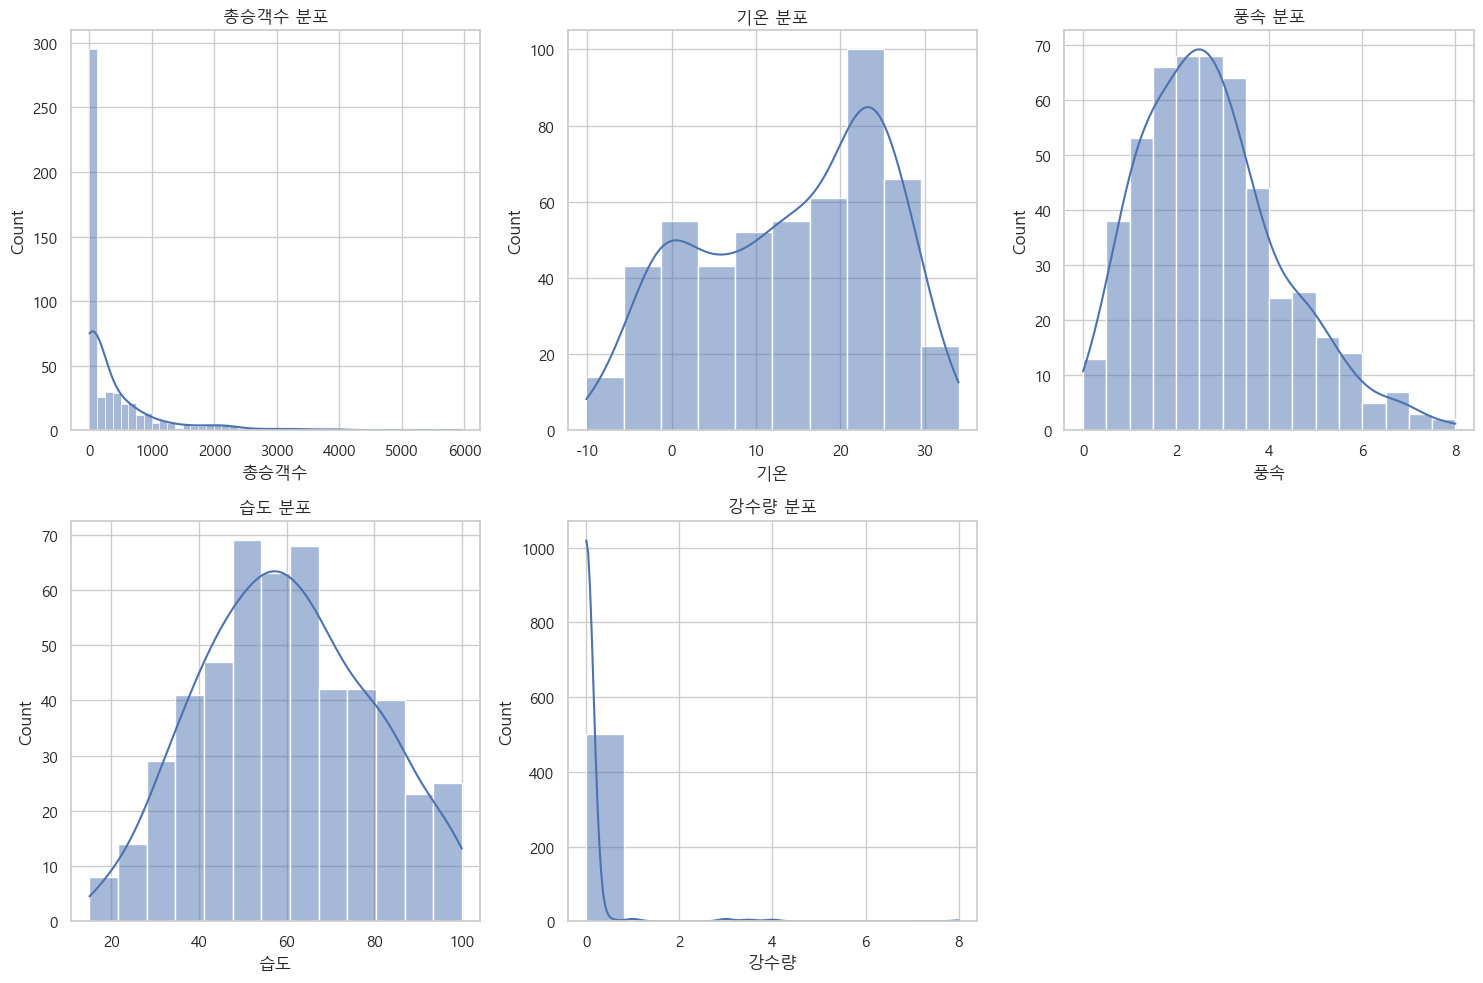

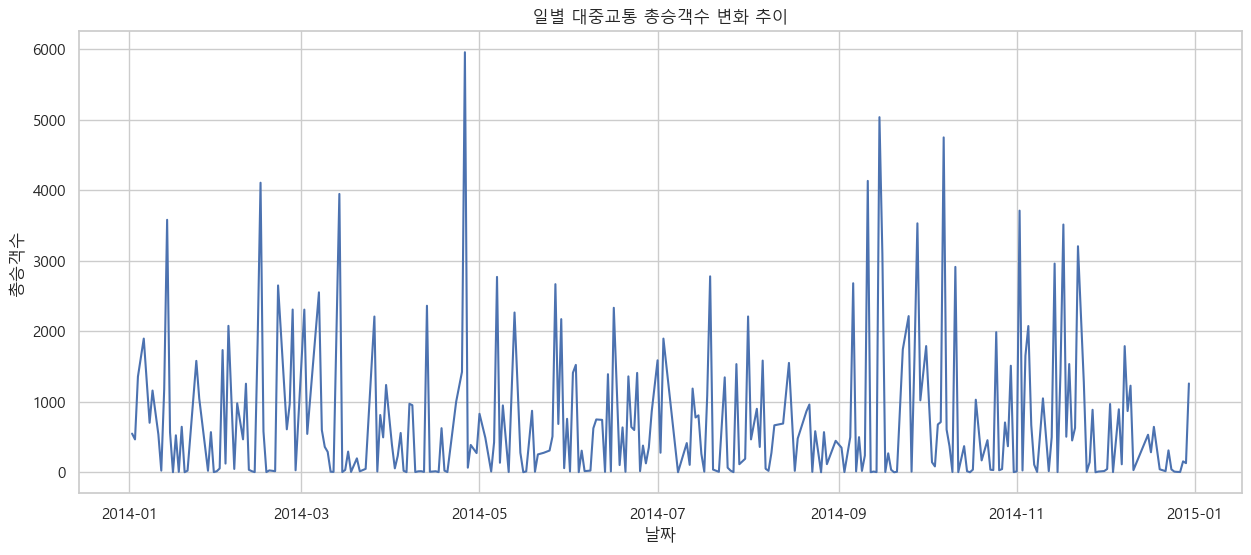

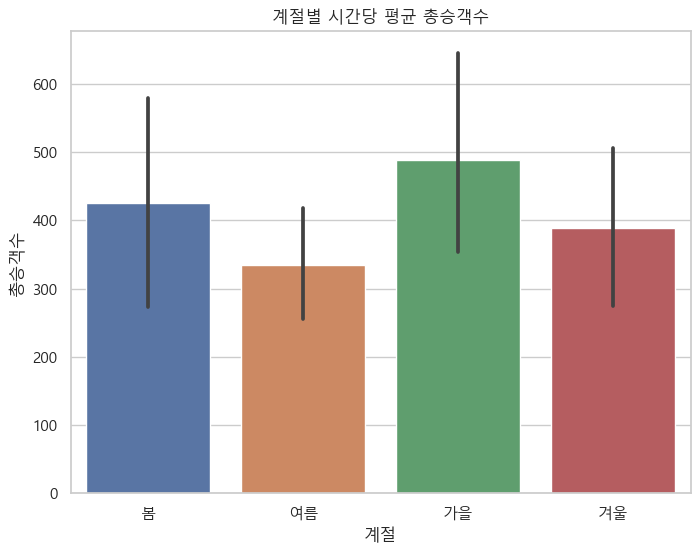

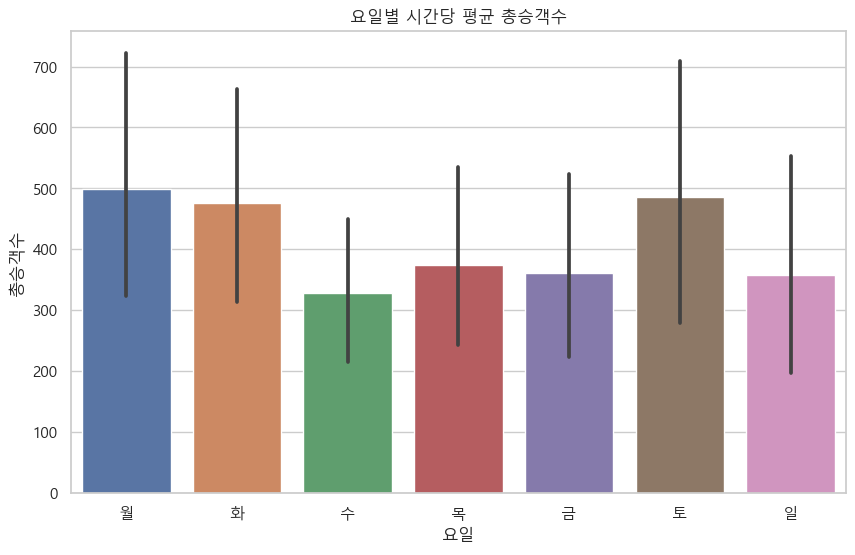

c:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\USER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


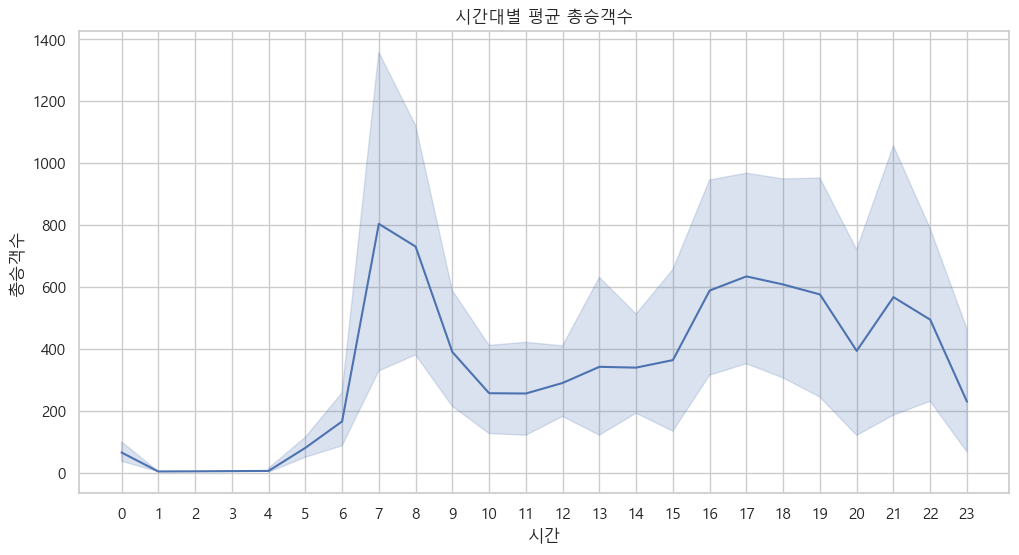

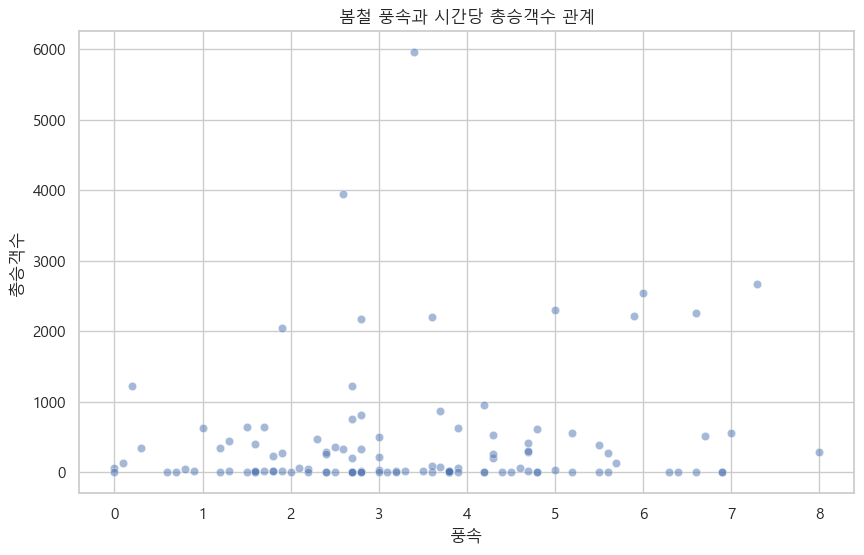

In [16]:
# # 5. EDA (탐색적 데이터 분석)

if not final_df.empty:
    print("\n--- EDA 시작 ---")
    
    # 5.1. 총승객수 및 주요 기상 변수 분포 확인
    plt.figure(figsize=(15, 10))
    plot_cols = ['총승객수', '기온', '풍속', '습도', '강수량'] # 적설은 0이 많을 수 있어 제외
    for i, col in enumerate(plot_cols):
        plt.subplot(2, 3, i+1)
        sns.histplot(final_df[col], kde=True)
        plt.title(f'{col} 분포')
    plt.tight_layout()
    plt.show()

    # 5.2. 시간에 따른 총승객수 변화 (일별)
    # 일별 총 승객수로 집계하여 시각화 (너무 많으면 일부 기간만)
    daily_passengers = final_df.groupby(final_df['날짜'].dt.date)['총승객수'].sum()
    plt.figure(figsize=(15, 6))
    daily_passengers.plot()
    plt.title('일별 대중교통 총승객수 변화 추이')
    plt.xlabel('날짜')
    plt.ylabel('총승객수')
    plt.show()

    # 5.3. 계절별 평균 총승객수
    plt.figure(figsize=(8, 6))
    sns.barplot(x='계절', y='총승객수', data=final_df, estimator=np.mean, order=['봄', '여름', '가을', '겨울'])
    plt.title('계절별 시간당 평균 총승객수')
    plt.show()

    # 5.4. 요일별 평균 총승객수
    plt.figure(figsize=(10, 6))
    sns.barplot(x='요일', y='총승객수', data=final_df, estimator=np.mean, order=['월','화','수','목','금','토','일'])
    plt.title('요일별 시간당 평균 총승객수')
    plt.show()

    # 5.5. 시간대별 평균 총승객수
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='시간', y='총승객수', data=final_df, estimator=np.mean)
    plt.title('시간대별 평균 총승객수')
    plt.xticks(range(0,24))
    plt.grid(True)
    plt.show()
    
    # 5.6. 봄철 풍속과 총승객수 산점도
    spring_df = final_df[final_df['계절'] == '봄']
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='풍속', y='총승객수', data=spring_df, alpha=0.5)
    plt.title('봄철 풍속과 시간당 총승객수 관계')
    plt.show()
    
else:
    print("분석할 데이터가 없어 EDA를 건너뜁니다.")


--- 통계 분석 시작 ---

--- T-검정: 출퇴근 시간 vs 비출퇴근 시간 기상 데이터 차이 ---
    계절   변수  T-statistic   p-value
0    봄   기온    -2.599638  0.010889
1    봄  강수량     0.157420  0.875201
2    봄   풍속    -1.824972  0.070881
3    봄   습도     3.103008  0.002506
4    봄   적설     1.000000  0.322778
5   여름   기온    -2.647703  0.009349
6   여름  강수량     0.863036  0.391268
7   여름   풍속    -0.442726  0.658855
8   여름   습도     2.533458  0.012643
9   여름   적설          NaN       NaN
10  가을   기온    -1.895913  0.060232
11  가을  강수량    -1.711614  0.090489
12  가을   풍속    -1.319578  0.189184
13  가을   습도     2.009094  0.046546
14  가을   적설          NaN       NaN
15  겨울   기온    -2.576846  0.011226
16  겨울  강수량     1.000000  0.321941
17  겨울   풍속    -2.228805  0.027856
18  겨울   습도     2.564000  0.011662
19  겨울   적설     1.357802  0.177571

* 해석: p-value가 0.05보다 크면 출퇴근 시간과 비출퇴근 시간 간에 해당 기상 변수의 평균값에 통계적으로 유의미한 차이가 없다고 볼 수 있습니다.

--- 계절별 상관 분석 (총승객수 vs 기상변수) ---


c:\Users\USER\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
c:\Users\USER\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
c:\Users\USER\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
c:\Users\USER\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


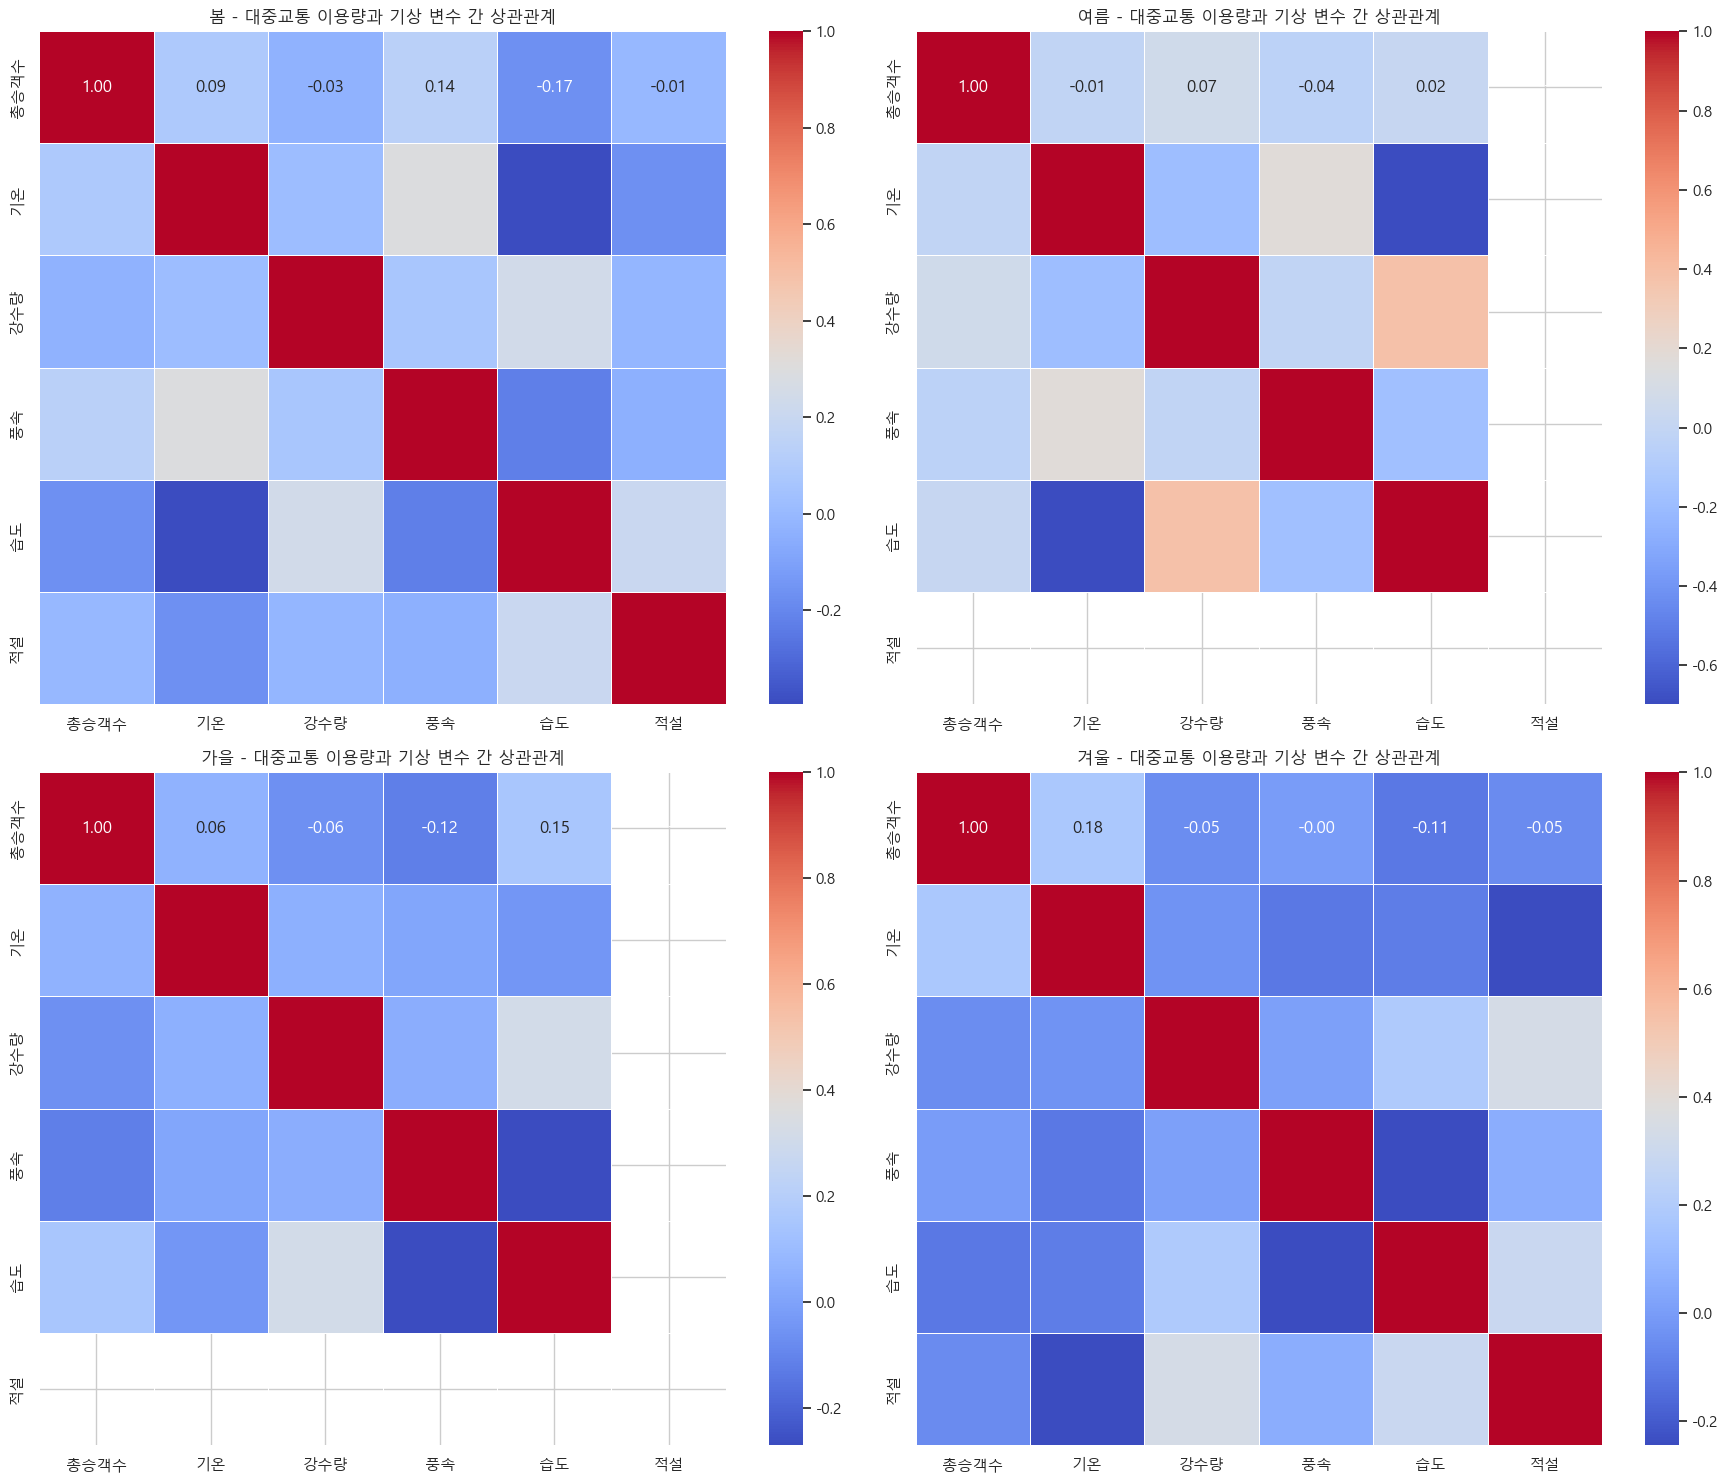


--- 상관계수 및 p-value 결과 ---
    계절   변수      상관계수   p-value
0    봄   기온  0.087959  0.354231
1    봄  강수량 -0.032664  0.731258
2    봄   풍속  0.135657  0.151957
3    봄   습도 -0.167606  0.075991
4    봄   적설 -0.007117  0.940361
5   여름   기온 -0.012444  0.887385
6   여름  강수량  0.066079  0.451577
7   여름   풍속 -0.038233  0.663381
8   여름   습도  0.015134  0.863254
9   여름   적설       NaN       NaN
10  가을   기온  0.059052  0.475891
11  가을  강수량 -0.063783  0.441206
12  가을   풍속 -0.117654  0.154408
13  가을   습도  0.149023  0.070657
14  가을   적설       NaN       NaN
15  겨울   기온  0.177852  0.054006
16  겨울  강수량 -0.053125  0.567762
17  겨울   풍속 -0.004210  0.963908
18  겨울   습도 -0.112958  0.223272
19  겨울   적설 -0.054658  0.556629

* 해석: p-value가 0.05보다 작을 때 상관계수가 통계적으로 유의미하다고 판단합니다.
* 상관계수의 절대값이 클수록 강한 관계를 의미합니다 (일반적으로 |0.7| 이상 강한, |0.3|-|0.7| 보통, |0.1|-|0.3| 약한, |0.1| 미만 거의 없음).

--- 회귀 분석 (예: 봄철 데이터, 종속변수: 총승객수) ---

--- 봄철: 총승객수 ~ 풍속 (단순 선형 회귀) ---
                            OLS Regression Results                         

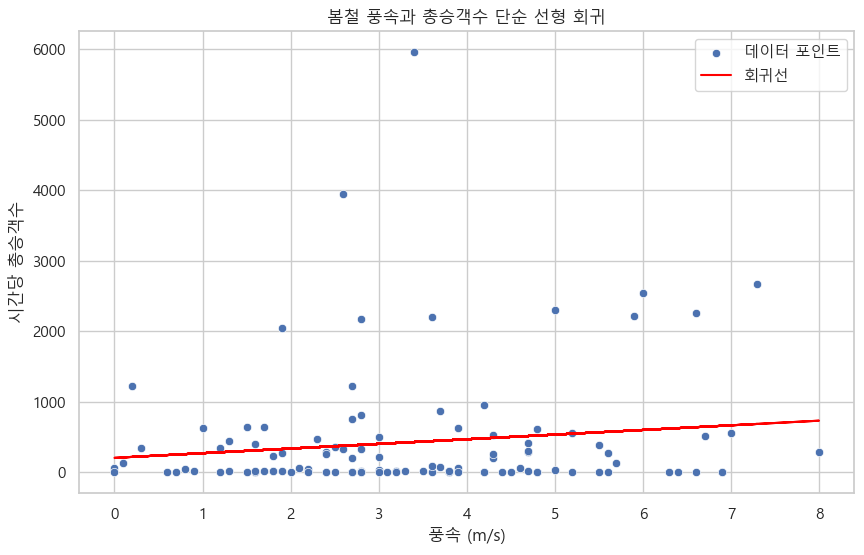


--- 봄철: 총승객수 ~ 풍속 + 기온 + 습도 + 강수량 (다중 선형 회귀) ---
                            OLS Regression Results                            
Dep. Variable:             passengers   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     1.321
Date:                Fri, 09 May 2025   Prob (F-statistic):              0.163
Time:                        14:47:14   Log-Likelihood:                -902.57
No. Observations:                 113   AIC:                             1867.
Df Residuals:                      82   BIC:                             1952.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [17]:
# # 6. 통계 분석

if not final_df.empty:
    print("\n--- 통계 분석 시작 ---")

    # ## 6.1. T-검정 (출퇴근 시간 vs 비출퇴근 시간 기상 데이터 차이)
    # ### 원본 노트북의 분석을 유지. 이 분석의 목적/가설을 명확히 기술하면 좋음.
    
    print("\n--- T-검정: 출퇴근 시간 vs 비출퇴근 시간 기상 데이터 차이 ---")
    ttest_results_list = []
    weather_vars_for_ttest = ['기온', '강수량', '풍속', '습도', '적설']
    
    for season in ['봄', '여름', '가을', '겨울']:
        season_data = final_df[final_df['계절'] == season]
        if season_data.empty:
            continue
        
        commute_data = season_data[season_data['출퇴근구분'] == '출퇴근시간']
        non_commute_data = season_data[season_data['출퇴근구분'] == '비출퇴근시간']
        
        for var in weather_vars_for_ttest:
            if commute_data[var].dropna().empty or non_commute_data[var].dropna().empty:
                stat, p_val = np.nan, np.nan
            else:
                # 등분산성 가정을 하지 않음 (Welch's t-test)
                stat, p_val = ttest_ind(commute_data[var].dropna(), non_commute_data[var].dropna(), equal_var=False)
            ttest_results_list.append({'계절': season, '변수': var, 'T-statistic': stat, 'p-value': p_val})

    ttest_df = pd.DataFrame(ttest_results_list)
    print(ttest_df)
    print("\n* 해석: p-value가 0.05보다 크면 출퇴근 시간과 비출퇴근 시간 간에 해당 기상 변수의 평균값에 통계적으로 유의미한 차이가 없다고 볼 수 있습니다.")


    # ## 6.2. 계절별 상관 분석 (Pearson)
    print("\n--- 계절별 상관 분석 (총승객수 vs 기상변수) ---")
    correlation_results_list = []
    
    plt.figure(figsize=(18, 15)) # 전체 그림 크기
    
    for i, season in enumerate(['봄', '여름', '가을', '겨울']):
        plt.subplot(2, 2, i+1) # 2x2 그리드에 서브플롯 생성
        season_data = final_df[final_df['계절'] == season]
        if season_data.empty or len(season_data) < 2: # 데이터가 없거나 너무 적으면 스킵
            print(f"{season} 데이터가 부족하여 상관분석을 건너뜁니다.")
            continue

        analysis_cols = ['총승객수', '기온', '강수량', '풍속', '습도', '적설']
        season_corr = season_data[analysis_cols].corr(method='pearson')
        
        sns.heatmap(season_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title(f'{season} - 대중교통 이용량과 기상 변수 간 상관관계')

        for var in ['기온', '강수량', '풍속', '습도', '적설']:
            if season_data[var].isnull().all() or season_data['총승객수'].isnull().all() or len(season_data[[var, '총승객수']].dropna()) < 2 :
                 corr, p_val = np.nan, np.nan
            else:
                clean_pair = season_data[[var, '총승객수']].dropna()
                corr, p_val = pearsonr(clean_pair[var], clean_pair['총승객수'])
            correlation_results_list.append({'계절': season, '변수': var, '상관계수': corr, 'p-value': p_val})
            
    plt.tight_layout()
    plt.show()

    correlation_df = pd.DataFrame(correlation_results_list)
    print("\n--- 상관계수 및 p-value 결과 ---")
    print(correlation_df)
    print("\n* 해석: p-value가 0.05보다 작을 때 상관계수가 통계적으로 유의미하다고 판단합니다.")
    print("* 상관계수의 절대값이 클수록 강한 관계를 의미합니다 (일반적으로 |0.7| 이상 강한, |0.3|-|0.7| 보통, |0.1|-|0.3| 약한, |0.1| 미만 거의 없음).")


    # ## 6.3. 회귀 분석 (예: 봄철 풍속)
    # ### statsmodels.formula.api.ols 사용 (더 풍부한 결과 제공)
    print("\n--- 회귀 분석 (예: 봄철 데이터, 종속변수: 총승객수) ---")
    spring_df_reg = final_df[final_df['계절'] == '봄'].copy()

    if not spring_df_reg.empty and len(spring_df_reg.dropna(subset=['총승객수', '풍속', '기온', '습도', '강수량'])) > 5: # 충분한 데이터가 있는지 확인
        # 컬럼명에 특수문자나 한글이 있으면 formula에서 오류 발생 가능 -> 영어로 변경
        spring_df_reg.rename(columns={
            '총승객수': 'passengers',
            '풍속': 'wind_speed',
            '기온': 'temp',
            '습도': 'humidity',
            '강수량': 'precipitation'
            # 적설은 봄에 데이터가 거의 없을 수 있으므로 제외하거나 확인 후 추가
        }, inplace=True)

        # 단순 선형 회귀 (풍속)
        print("\n--- 봄철: 총승객수 ~ 풍속 (단순 선형 회귀) ---")
        try:
            model_simple = smf.ols(formula='passengers ~ wind_speed', data=spring_df_reg).fit()
            print(model_simple.summary())
            
            # 회귀계수 해석
            wind_coef_simple = model_simple.params['wind_speed']
            print(f"\n* 해석: 다른 조건이 일정할 때, 봄철 풍속이 1m/s 증가하면 시간당 총승객수는 약 {wind_coef_simple:.2f}명 증가(또는 감소)하는 것으로 나타납니다.")
            print(f"  (p-value: {model_simple.pvalues['wind_speed']:.3f}, R-squared: {model_simple.rsquared:.3f})")

            # 시각화
            plt.figure(figsize=(10,6))
            sns.scatterplot(x='wind_speed', y='passengers', data=spring_df_reg, label='데이터 포인트')
            plt.plot(spring_df_reg['wind_speed'], model_simple.predict(spring_df_reg['wind_speed']), color='red', label='회귀선')
            plt.title('봄철 풍속과 총승객수 단순 선형 회귀')
            plt.xlabel('풍속 (m/s)')
            plt.ylabel('시간당 총승객수')
            plt.legend()
            plt.show()

        except Exception as e:
            print(f"단순 선형 회귀 분석 중 오류 발생: {e}")


        # 다중 선형 회귀 (풍속, 기온, 습도, 강수량)
        print("\n--- 봄철: 총승객수 ~ 풍속 + 기온 + 습도 + 강수량 (다중 선형 회귀) ---")
        try:
            # 요일, 시간대 등 다른 요인도 통제변수로 추가하면 모델 설명력이 높아질 수 있습니다.
            # 예: formula='passengers ~ wind_speed + temp + humidity + precipitation + C(요일코드) + C(시간)'
            # C()는 범주형 변수임을 나타냄
            model_multiple = smf.ols(formula='passengers ~ wind_speed + temp + humidity + precipitation + C(요일코드) + C(시간)', data=spring_df_reg).fit()
            print(model_multiple.summary())
            
            wind_coef_multiple = model_multiple.params.get('wind_speed', np.nan) # get으로 안전하게 접근
            print(f"\n* 해석 (다중회귀): 다른 변수들이 통제된 상태에서, 봄철 풍속이 1m/s 증가하면 시간당 총승객수는 약 {wind_coef_multiple:.2f}명 변화합니다.")
            print(f"  (풍속 p-value: {model_multiple.pvalues.get('wind_speed', np.nan):.3f}, 전체 모델 R-squared: {model_multiple.rsquared:.3f})")
            print("* 다른 변수들의 계수와 p-value도 함께 확인하여 해석해야 합니다.")
        
        except Exception as e:
            print(f"다중 선형 회귀 분석 중 오류 발생: {e}")
            
    else:
        print("봄철 데이터가 부족하거나 주요 변수에 결측치가 많아 회귀분석을 건너뜁니다.")
else:
    print("분석할 데이터가 없어 통계 분석을 건너뜁니다.")

In [18]:
# # 7. 결론 및 논의

print("\n--- 프로젝트 결론 및 논의 ---")
# 이 부분은 위 분석 결과들을 바탕으로 원태찬님께서 직접 작성해주시는 것이 좋습니다.
# 예시:
# 1. 주요 발견 사항 요약 (예: 봄철 풍속과의 관계, 다른 계절/변수의 미미한 영향 등)
# 2. 발견 사항에 대한 해석 및 추론 (예: 왜 봄철 풍속만 유의미했을까? 데이터의 한계는 아니었을까?)
# 3. 분석의 한계점 (예: 사용 데이터의 기간, 고려하지 못한 변수 - 미세먼지, 공휴일, 행사 등)
# 4. 향후 분석 방향 또는 개선 아이디어 (예: 시간 지연 효과(lag) 고려, 특정 노선/지역 심층 분석, 머신러닝 모델 활용 등)

# 원본 노트북의 결론을 참고하여 작성:
# "풍속(m/s)만 봄에 대중교통 이용량과 유의미한 양의 상관관계를 보임 (p-value < 0.05)."
# "회귀분석 결과, 다른 변수들이 통제되었을 때도 봄철 풍속은 대중교통 이용량에 유의미한 양의 영향을 미치는 것으로 나타남 (계수: [값], p-value: [값])."
# "여름, 가을, 겨울에서는 다른 기상 변수들이 대중교통 이용량에 통계적으로 유의미한 영향을 미치지 않는 것으로 보임."
# "다만, 본 분석은 특정 기간의 데이터를 사용하였으며, 미세먼지 농도나 특정 사회적 이벤트 등 다른 외부 요인을 고려하지 않은 한계가 있음."
# "향후 미세먼지 데이터를 포함하거나, 주말/공휴일 효과를 명시적으로 모델에 포함하여 분석하면 더 정확한 결과를 얻을 수 있을 것으로 기대됨."

# 위 회귀분석 결과(model_multiple.summary())를 바탕으로 결론을 구체적으로 작성하세요.


--- 프로젝트 결론 및 논의 ---
